## やりたいこと
`proto2021.py`のリカレントオートエンコーダ化検討

In [1]:
import os

os.chdir("C:\\Users\\amane\\OneDrive\\python\\proto2021\\bin")
print(os.getcwd())

C:\Users\amane\OneDrive\python\proto2021\bin


In [2]:
import numpy as np
X = np.load(".\\data\\proto2021_train_ds.npz")
X_train = X["X"]
del X

In [3]:
X_train.shape

(1536, 513, 147)

---
4層のノイズ除去リカレントオートエンコーダ 入出力段で行列を転置し、スペクトログラムの横軸(列方向)がタイムステップになるように調整

Epoch 1/1000
46/46 [==============================] - 18s 389ms/step - loss: 0.6410 - accuracy: 0.0028 - val_loss: 0.6188 - val_accuracy: 0.0024
Epoch 2/1000
46/46 [==============================] - 16s 358ms/step - loss: 0.6285 - accuracy: 0.0027 - val_loss: 0.6173 - val_accuracy: 0.0021
Epoch 3/1000
46/46 [==============================] - 16s 352ms/step - loss: 0.6243 - accuracy: 0.0026 - val_loss: 0.6056 - val_accuracy: 0.0022
Epoch 4/1000
46/46 [==============================] - 17s 365ms/step - loss: 0.6165 - accuracy: 0.0026 - val_loss: 0.6038 - val_accuracy: 0.0029
Epoch 5/1000
46/46 [==============================] - 19s 411ms/step - loss: 0.6152 - accuracy: 0.0027 - val_loss: 0.6017 - val_accuracy: 0.0022
Epoch 6/1000
46/46 [==============================] - 20s 429ms/step - loss: 0.6149 - accuracy: 0.0030 - val_loss: 0.6015 - val_accuracy: 0.0023
Epoch 7/1000
46/46 [==============================] - 21s 456ms/step - loss: 0.6147 - accuracy: 0.0032 - val_loss: 0.6013 - val_ac

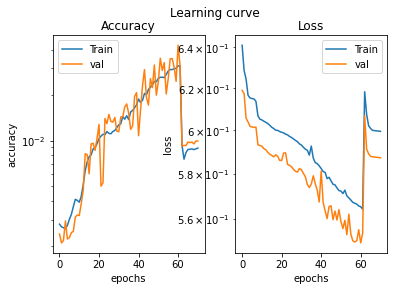

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def def_early_stopping():
    return tf.keras.callbacks.EarlyStopping(
            monitor = "val_loss",
            patience= 10,
            min_delta = 0.0001)

def def_reduce():
    return tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_loss",
            patience = 5,
            verbose= 1)

encoder = tf.keras.models.Sequential([
    tf.keras.layers.Permute((2,1),input_shape=[X_train.shape[1], X_train.shape[2]]),
    tf.keras.layers.GaussianNoise(0.2),
    tf.keras.layers.GRU(int(X_train.shape[1] / 2), return_sequences=True),
    tf.keras.layers.GRU(int(X_train.shape[1] / 2 /2), return_sequences=True),
    tf.keras.layers.GRU(int(X_train.shape[1] / 2 /2 / 2), return_sequences=True),
    tf.keras.layers.GRU(int(X_train.shape[1] / 2 / 2 / 2 / 2))
],name = "encoder")
decoder = tf.keras.models.Sequential([
    tf.keras.layers.RepeatVector(X_train.shape[2], input_shape=[int(X_train.shape[1] / 2 / 2 / 2 / 2)]),
    tf.keras.layers.GRU(int(X_train.shape[1] / 2 / 2 / 2), return_sequences=True),
    tf.keras.layers.GRU(int(X_train.shape[1] / 2 / 2), return_sequences=True),
    tf.keras.layers.GRU(int(X_train.shape[1] / 2), return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(X_train.shape[1], activation="sigmoid")),
    tf.keras.layers.Permute((2,1))
],name = "decoder")
rec_ae = tf.keras.models.Sequential([encoder, decoder],name = "autoencoder")
rec_ae.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Nadam(),
                     metrics=["accuracy"])

cb_es = def_early_stopping()
cb_rd = def_reduce()
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train.reshape(len(X_train),-1)).reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2])
hist = rec_ae.fit(X_train, X_train, epochs=1000, validation_split = 0.05,callbacks=[cb_es,cb_rd],shuffle = True,use_multiprocessing=True)
X_train = scaler.inverse_transform(X_train.reshape(len(X_train),-1)).reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2])

rec_ae.summary()

plt.subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.yscale("log")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["Train","val"])
plt.title("Accuracy")

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Train","val"])
plt.title("Loss")

plt.suptitle("Learning curve")
plt.show()

セル数が周波数方向(513次元)しかないので、驚異的な速度で学習が進む

In [5]:
X = np.load(".\\data\\proto2021_test_ds.npz")
X_test = X["X"]
y_test = X["y"]
del X

X_test = scaler.transform(X_test.reshape(len(X_test),-1)).reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])
X_dec = rec_ae.predict(X_test)
X_test = scaler.inverse_transform(X_test.reshape(len(X_test),-1)).reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])
X_dec = scaler.inverse_transform(X_dec.reshape(len(X_dec),-1)).reshape(X_dec.shape[0],X_dec.shape[1],X_dec.shape[2])

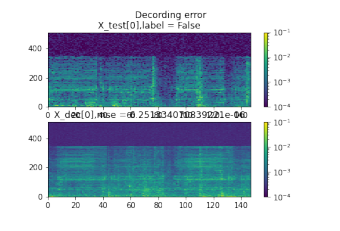

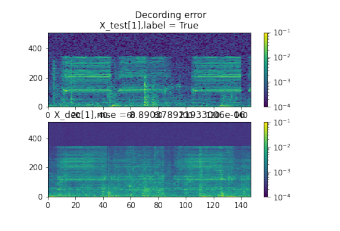

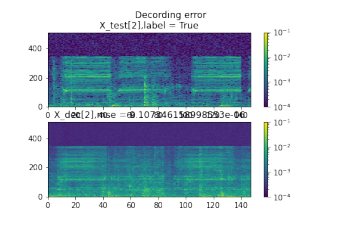

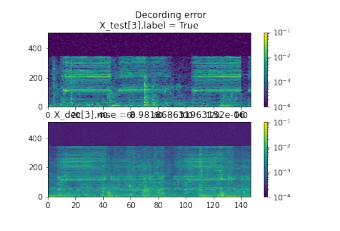

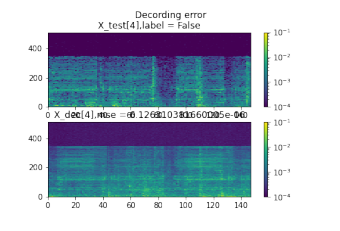

In [7]:
from matplotlib.colors import LogNorm
from sklearn.metrics import mean_squared_error
mse = np.zeros(X_test.shape[0])
for i in range(len(X_test)):
    mse[i] = mean_squared_error(X_test[i],X_dec[i])


for i in range(5):
    plt.subplot(2,1,1)
    plt.pcolormesh(X_test[i],norm = LogNorm(vmax = 1e-01,vmin = 1e-04))
    plt.colorbar()
    plt.title("X_test[{0}],label = {1}".format(i,str(y_test[i])))
    plt.subplot(2,1,2)
    plt.pcolormesh(X_dec[i],norm = LogNorm(vmax = 1e-01,vmin = 1e-04))
    plt.colorbar()
    plt.title("X_dec[{0}],mse = {1}".format(i,mse[i]))
    plt.suptitle("Decording error")
    plt.savefig("image.png")
    plt.close()

    img = plt.imread("image.png")
    plt.imshow(img)
    plt.axis("off")
    plt.show()